# Оптимизация выбора локации скважины

**Описание проекта:**   
Мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Нужно проанализировать возможную прибыль и риски техникой *Bootstrap.*

**Цель исследования:**   
Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

**Описание данных:**   
Три датасета с данными по каждому из регионов. Внутри каждого из них уникальный идентификатор скважины, три признака точек и объём запасов в скважине (тыс. баррелей).


**Ход исследования:**
- [1. Загрузка и подготовка данных](#загрузка)
- [2. Обучение и проверка модели](#обучение)
- [3. Подготовка к расчёту прибыли](#подготовка)
- [4. Расчёт прибыли и рисков](#расчет)
- [5. Чек-лист готовности проекта](#чек-лист)

**Общий вывод:**   
После анализа данных при использовании техники Bootstrap был найден регион, в котором с самой высокой прибылью и самыми низкими рисками - это Регион 2

<a id="загрузка"></a>  
## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

RANDOM_STATE = 42
TEST_SIZE = 0.25

pd.options.display.float_format = '{:,.1f}'.format

In [2]:
try:
    df1 = pd.read_csv('/datasets/geo_data_0.csv')
except:
    df1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
df1.head()

,id,f0,f1,f2,product
0,txEyH,0.7,-0.5,1.2,105.3
1,2acmU,1.3,-0.3,4.4,73.0
2,409Wp,1.0,0.2,1.4,85.3
3,iJLyR,-0.0,0.1,3.0,168.6
4,Xdl7t,2.0,0.2,4.8,154.0


In [3]:
try:
    df2 = pd.read_csv('/datasets/geo_data_1.csv')
except:
    df2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
df2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.0,-8.3,-0.0,3.2
1,62mP7,14.3,-3.5,1.0,27.0
2,vyE1P,6.3,-5.9,5.0,134.8
3,KcrkZ,-13.1,-11.5,5.0,137.9
4,AHL4O,12.7,-8.1,5.0,134.8


In [4]:
try:
    df3 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    df3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')
df3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.1,1.0,-0.8,27.8
1,WJtFt,0.3,0.3,-2.5,56.1
2,ovLUW,0.2,0.3,-5.6,62.9
3,q6cA6,2.2,-0.6,0.9,114.6
4,WPMUX,-0.5,1.7,5.9,149.6


In [5]:
def opening (df1):
    print('ПЕРВЫЕ ПЯТЬ СТРОК')
    display(df1.head())
    
    print('ИНФОРМАЦИЯ О ДАННЫХ')
    df1.info()
    print('\n')
    
    print('КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ')
    print(df1.isna().sum(), '\n')
    
    print('КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ, %')
    print(df1.isna().mean()*100, '\n')
    
    print('ОПИСАНИЕ ЧИСЛОВЫХ ДАННЫХ')
    print(df1.describe(), '\n')
    
    print('УНИКАЛЬНЫЕ ЗНАЧЕНИЯ КАТЕГОРИАЛЬНЫХ ДАННЫХ')
    cat_cols = df1.select_dtypes(include = ['object', 'category'])
    for i in cat_cols:
        print(f'{i}: {df1[i].nunique()} уникальные значения - {df1[i].unique()}')
    print('\n')
    
    print('КОЛИЧЕСТВО ДУБЛИКАТОВ')
    print(df1.duplicated().sum())
    
    print('РАСПРЕДЕЛЕНИЕ ДАННЫХ КОЛИЧЕСТВЕННЫХ СТОЛБЦОВ')
    df1.hist(figsize=(15,10), bins=20)

ПЕРВЫЕ ПЯТЬ СТРОК


,id,f0,f1,f2,product
0,txEyH,0.7,-0.5,1.2,105.3
1,2acmU,1.3,-0.3,4.4,73.0
2,409Wp,1.0,0.2,1.4,85.3
3,iJLyR,-0.0,0.1,3.0,168.6
4,Xdl7t,2.0,0.2,4.8,154.0


ИНФОРМАЦИЯ О ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ, %
id        0.0
f0        0.0
f1        0.0
f2        0.0
product   0.0
dtype: float64 

ОПИСАНИЕ ЧИСЛОВЫХ ДАННЫХ
             f0        f1        f2   product
count 100,000.0 100,000.0 100,000.0 100,000.0
mean        0.5       0.3       2.5      92.5
std         0.9       0.5       3.2      44.3
min        -1.4      -0.8     -12.1       0.0
25%        -0.1      -0.2       0.3      56.5
50%      

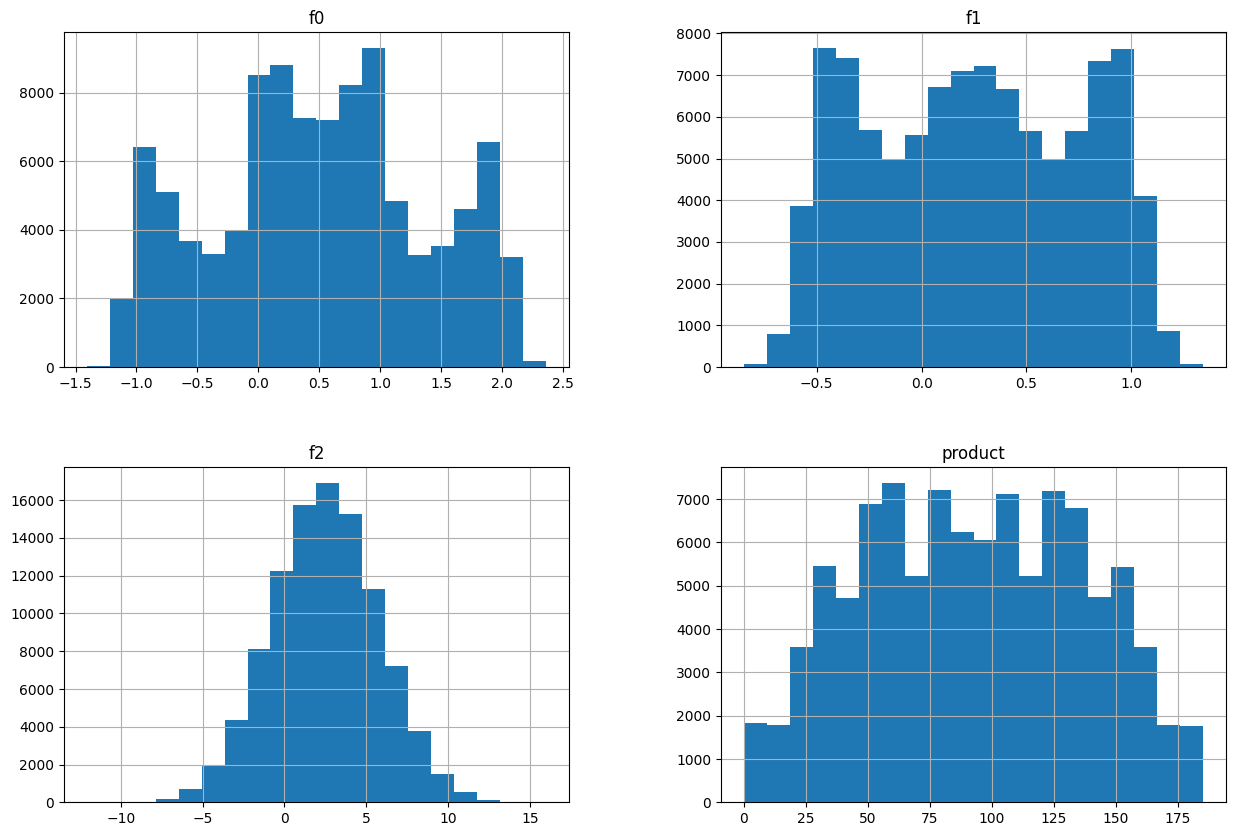

In [6]:
opening(df1)

ПЕРВЫЕ ПЯТЬ СТРОК


,id,f0,f1,f2,product
0,kBEdx,-15.0,-8.3,-0.0,3.2
1,62mP7,14.3,-3.5,1.0,27.0
2,vyE1P,6.3,-5.9,5.0,134.8
3,KcrkZ,-13.1,-11.5,5.0,137.9
4,AHL4O,12.7,-8.1,5.0,134.8


ИНФОРМАЦИЯ О ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ, %
id        0.0
f0        0.0
f1        0.0
f2        0.0
product   0.0
dtype: float64 

ОПИСАНИЕ ЧИСЛОВЫХ ДАННЫХ
             f0        f1        f2   product
count 100,000.0 100,000.0 100,000.0 100,000.0
mean        1.1      -4.8       2.5      68.8
std         9.0       5.1       1.7      45.9
min       -31.6     -26.4      -0.0       0.0
25%        -6.3      -8.3       1.0      27.0
50%      

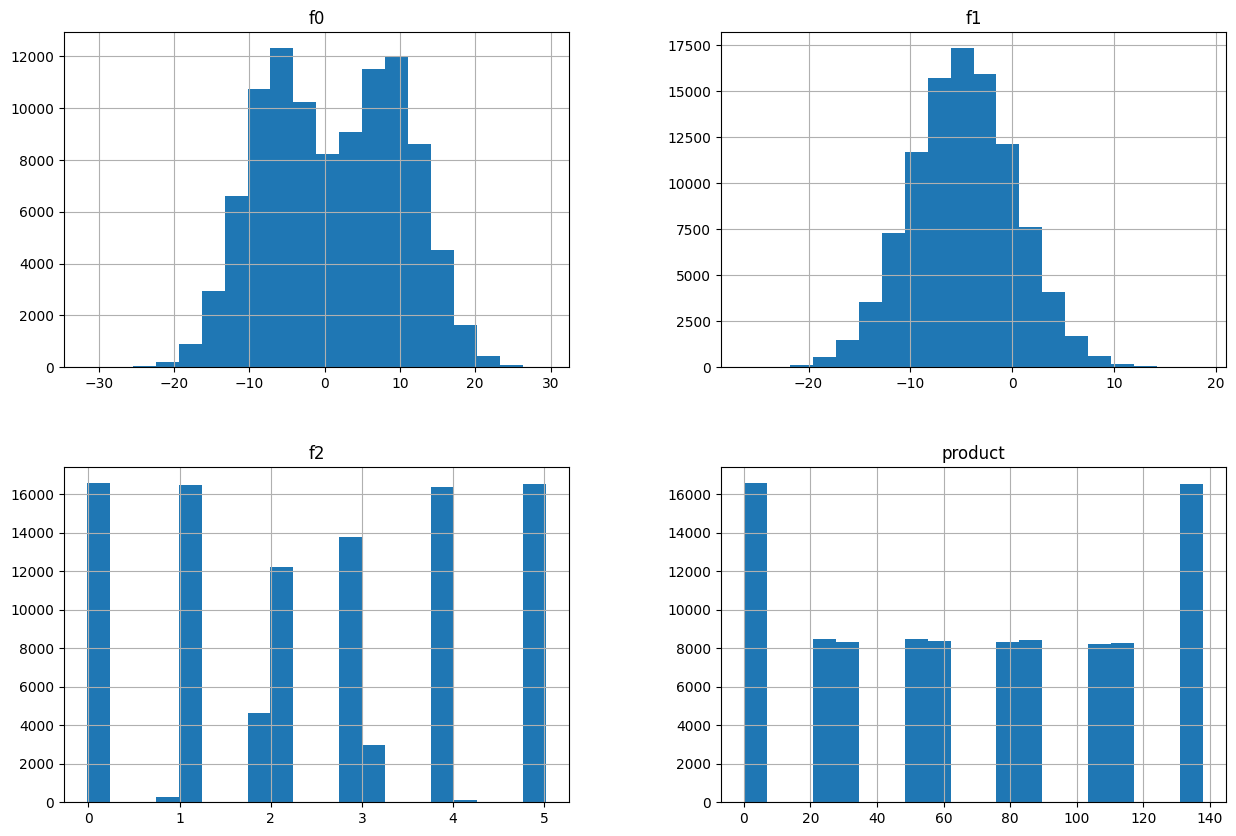

In [7]:
opening(df2)

ПЕРВЫЕ ПЯТЬ СТРОК


,id,f0,f1,f2,product
0,fwXo0,-1.1,1.0,-0.8,27.8
1,WJtFt,0.3,0.3,-2.5,56.1
2,ovLUW,0.2,0.3,-5.6,62.9
3,q6cA6,2.2,-0.6,0.9,114.6
4,WPMUX,-0.5,1.7,5.9,149.6


ИНФОРМАЦИЯ О ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ, %
id        0.0
f0        0.0
f1        0.0
f2        0.0
product   0.0
dtype: float64 

ОПИСАНИЕ ЧИСЛОВЫХ ДАННЫХ
             f0        f1        f2   product
count 100,000.0 100,000.0 100,000.0 100,000.0
mean        0.0      -0.0       2.5      95.0
std         1.7       1.7       3.5      44.7
min        -8.8      -7.1     -12.0       0.0
25%        -1.2      -1.2       0.1      59.5
50%      

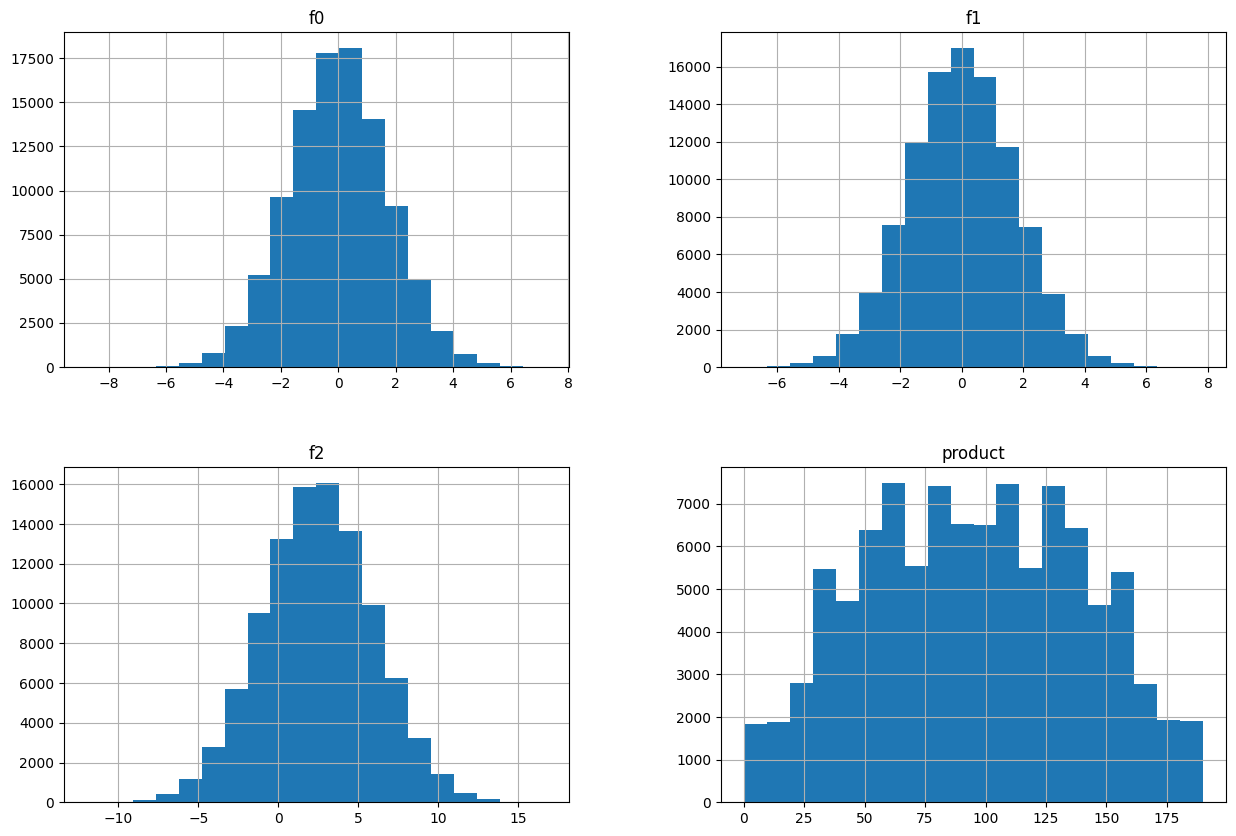

In [8]:
opening(df3)

У нас есть неявные дубликаты по колонке 'id' в каждом из датасетов. Оставим те, которые ближе к концу списка. Мотивируем это тем, что возможно это более свежие данные

In [9]:
df1 = df1.drop_duplicates(subset='id', keep='last')
df2 = df2.drop_duplicates(subset='id', keep='last')
df3 = df3.drop_duplicates(subset='id', keep='last')

print(df1.shape)
print(df2.shape)
print(df3.shape)

(99990, 5)
(99996, 5)
(99996, 5)


**Вывод по разделу:**
- У нас три датасета с данными о геолокациях скважин. В каждом есть id, три признака точек и объём запасов в скважине
- В первом и третьем датасете данные приближены к нормальному распеределению, Непрерывные количественные переменные
- Во втором датасете в f2 и product все данные кажутся непрерывными, но их значения лежат очень близко к целым числам
- Во всех датасетах избавились от неявных дубликатов путём удаления данные по одинаковым id. Удалили более "старые" данные

<a id="обучение"></a>  
## Обучение и проверка модели

Создадим три модели для каждого региона. Отмасштабируем цифры в колонках 'f0', 'f1', 'f2', разобьем выборки 3 к 1 и сделаем предсказания

In [10]:
X1 = df1[['f0', 'f1', 'f2']]
y1 = df1.drop(['id', 'f0', 'f1', 'f2'], axis=1)

X2 = df2[['f0', 'f1', 'f2']]
y2 = df2.drop(['id','f0', 'f1', 'f2'], axis=1)

X3 = df3[['f0', 'f1', 'f2']]
y3 = df3.drop(['id','f0', 'f1', 'f2'], axis=1)

num_col_names = ['f0', 'f1', 'f2']

In [11]:
X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1, random_state = RANDOM_STATE, test_size = TEST_SIZE)

scaler = StandardScaler()

X_train_scaled1 = scaler.fit_transform(X_train1[num_col_names])
X_val_scaled1 = scaler.transform(X_val1[num_col_names])

X_train1 = pd.DataFrame(X_train_scaled1, columns = num_col_names)
X_val1 = pd.DataFrame(X_val_scaled1, columns = num_col_names)

model = LinearRegression()
model.fit(X_train1, y_train1)
y_pred1 = model.predict(X_val1)

rmse1 = np.sqrt(mean_squared_error(y_val1, y_pred1))
mean_pred1 = y_pred1.mean()
mean_val1 = y_val1['product'].mean()

print('Средний запас (тыс. баррелей):', mean_val1)
print('Средний предсказанный запас (тыс. баррелей):', mean_pred1)
print('RMSE первой модели:', rmse1)

Средний запас (тыс. баррелей): 92.22418381862296
Средний предсказанный запас (тыс. баррелей): 92.36532054199266
RMSE первой модели: 37.80659070512707


In [12]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2, random_state = RANDOM_STATE, test_size = TEST_SIZE)

scaler = StandardScaler()

X_train_scaled2 = scaler.fit_transform(X_train2[num_col_names])
X_val_scaled2 = scaler.transform(X_val2[num_col_names])

X_train2 = pd.DataFrame(X_train_scaled2, columns = num_col_names)
X_val2 = pd.DataFrame(X_val_scaled2, columns = num_col_names)

model = LinearRegression()
model.fit(X_train2, y_train2)
y_pred2 = model.predict(X_val2)

rmse2 = np.sqrt(mean_squared_error(y_val2, y_pred2))
mean_pred2 = y_pred2.mean()
mean_val2 = y_val2['product'].mean()

print('Средний запас (тыс. баррелей):', mean_val2)
print('Средний предсказанный запас (тыс. баррелей):', mean_pred2)
print('RMSE второй модели:', rmse2)

Средний запас (тыс. баррелей): 69.04793826913262
Средний предсказанный запас (тыс. баррелей): 69.04412081335099
RMSE второй модели: 0.8907546230101846


In [13]:
X_train3, X_val3, y_train3, y_val3 = train_test_split(X3, y3, random_state = RANDOM_STATE, test_size = TEST_SIZE)

scaler = StandardScaler()

X_train_scaled3 = scaler.fit_transform(X_train3[num_col_names])
X_val_scaled3 = scaler.transform(X_val3[num_col_names])

X_train3 = pd.DataFrame(X_train_scaled3, columns = num_col_names)
X_val3 = pd.DataFrame(X_val_scaled3, columns = num_col_names)

model = LinearRegression()
model.fit(X_train3, y_train3)
y_pred3 = model.predict(X_val3)

rmse3 = np.sqrt(mean_squared_error(y_val3, y_pred3))
mean_pred3 = y_pred3.mean()
mean_val3 = y_val3['product'].mean()

print('Средний запас (тыс. баррелей):', mean_val3)
print('Средний предсказанный запас (тыс. баррелей):', mean_pred3)
print('RMSE третьей модели:', rmse3)

Средний запас (тыс. баррелей): 94.82484841065816
Средний предсказанный запас (тыс. баррелей): 94.91790172049363
RMSE третьей модели: 40.13849714263183


Получили средний запас, средний предсказанный запас по трем регионам и RMSE каждой из моделей. Далее переведем всё в удобный вид, сопоставим по id и сохраним результат в файл

In [14]:
y_pred1_df = pd.DataFrame(y_pred1, columns=['product_pred'])
y_pred2_df = pd.DataFrame(y_pred2, columns=['product_pred'])
y_pred3_df = pd.DataFrame(y_pred3, columns=['product_pred'])

In [15]:
y_val1_df = y_val1.join(df1['id'],how='left')
y_val1_df['product_pred'] = y_pred1_df['product_pred'].values
y_val1_df = y_val1_df[['id', 'product', 'product_pred']]
y_val1_df.head(3)

,id,product,product_pred
33971,GrdZm,46.4,85.8
22859,3kiU5,77.3,119.7
19453,7nul3,149.7,117.0


In [16]:
y_val2_df = y_val2.join(df2['id'],how='left')
y_val2_df['product_pred'] = y_pred2_df['product_pred'].values
y_val2_df = y_val2_df[['id', 'product', 'product_pred']]
y_val2_df.head(3)

,id,product,product_pred
33971,42gjK,3.2,2.4
24615,zvuV8,27.0,25.5
42680,NWHY3,53.9,55.5


In [17]:
y_val3_df = y_val3.join(df3['id'],how='left')
y_val3_df['product_pred'] = y_pred3_df['product_pred'].values
y_val3_df = y_val3_df[['id', 'product', 'product_pred']]
y_val3_df.head(3)

,id,product,product_pred
33970,wAtvR,131.9,76.1
24613,nVhyX,165.5,90.1
42679,ecze8,102.1,120.6


In [18]:
y_val1_df.to_csv('Прогноз, 1-ый регион.csv', index=False)
y_val2_df.to_csv('Прогноз, 2-ой регион.csv', index=False)
y_val3_df.to_csv('Прогноз, 3-ий регион.csv', index=False)

**Итог по разделу:**
- Обучили три модели МО линейной регрессии для каждого региона. 
- Сделали предсказания на валидационной выборке. 
- Посмотрели на средний запас сырья и средний запас предсказанного сырья по регионам. В 3 регионе его больше всего, далее идет первый регион. И сильно меньше во втором регионе
- RMSE в первой и третьей модели при этом около 40. Это довольно высокая ошибка. RMSE во второй модели же близок к нулю. Модель предсказывает почти идеально. Что-то во второй модели не так? 

<a id="подготовка"></a>  
## Подготовка к расчёту прибыли

Cохраним все ключевые значения для расчетов в переменных

In [19]:
POINTS_PER_REGION = 500  # 500 точек исследования
DEVELOP_POINTS = 200  # 200 лучших точек для разработки
BUDGET = 10000000000  # 10 млрд. рублей
PRICE_PER_BARREL = 450  # доход, руб за 1 баррель
UNIT_SIZE = 1000 
REVENUE_PER_UNIT = PRICE_PER_BARREL * UNIT_SIZE  # 450 000 рублей
RISK = 0.025  # 2,5% 

Рассчитаем безубыточный порог для всех 200 скважин и для одной скважины отдельно

In [20]:
total_barrel = BUDGET/REVENUE_PER_UNIT
point_barrel_mean =  total_barrel / DEVELOP_POINTS
print(f"Порог безубыточности для 200 скважин: {total_barrel:.2f} тыс. баррелей")
print(F"Порог на одну из 200 скважин: {point_barrel_mean:.2f} тыс. баррелей")

Порог безубыточности для 200 скважин: 22222.22 тыс. баррелей
Порог на одну из 200 скважин: 111.11 тыс. баррелей


In [21]:
mean_val = [mean_val1, mean_val2, mean_val3]

for i in range(3):
    if point_barrel_mean > mean_val[i]:
        print(f"{i+1}-я зона: порог безубыточности выше среднего запаса")
    else:
        print(f"{i+1}-я зона: порог безубыточности ниже среднего запаса")

1-я зона: порог безубыточности выше среднего запаса
2-я зона: порог безубыточности выше среднего запаса
3-я зона: порог безубыточности выше среднего запаса


**Вывод по разделу:**  
- все ключевые значения для расчётов сохранили в отдельных переменных
- безубыточный порог для одной скважины - 111.11 тыс баррелей
- порог безубыточности выше, чем среднее значение всех скважин каждого из трех регионов

<a id="расчет"></a>  
## Расчёт прибыли и рисков 

Создадим функцию для подсчета прибыли и рисков сразу для трех регионов

Регион: Регион 1
Средняя прибыль: 404725537
95% интервал: -128938941 - 868914568
Риск убытков: 6.2 %


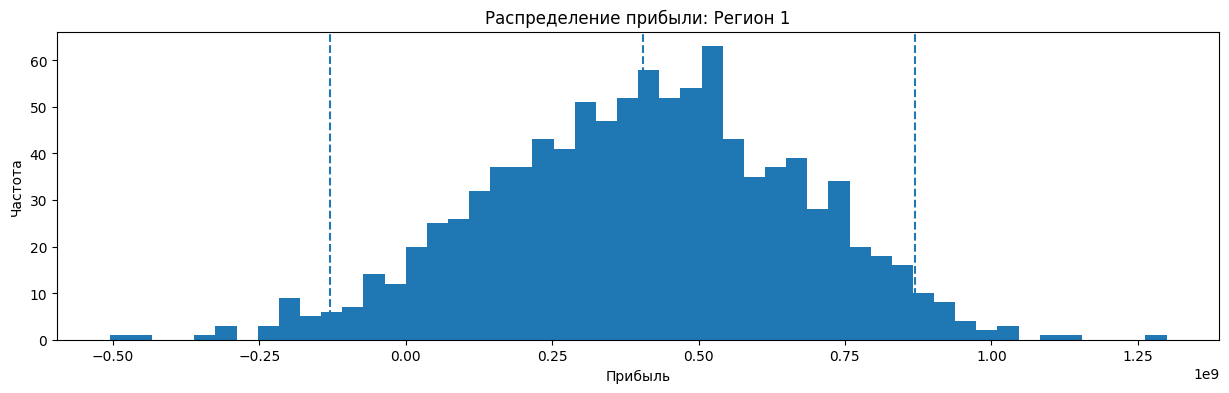

Регион: Регион 2
Средняя прибыль: 456228409
95% интервал: 46641450 - 845963731
Риск убытков: 1.5 %


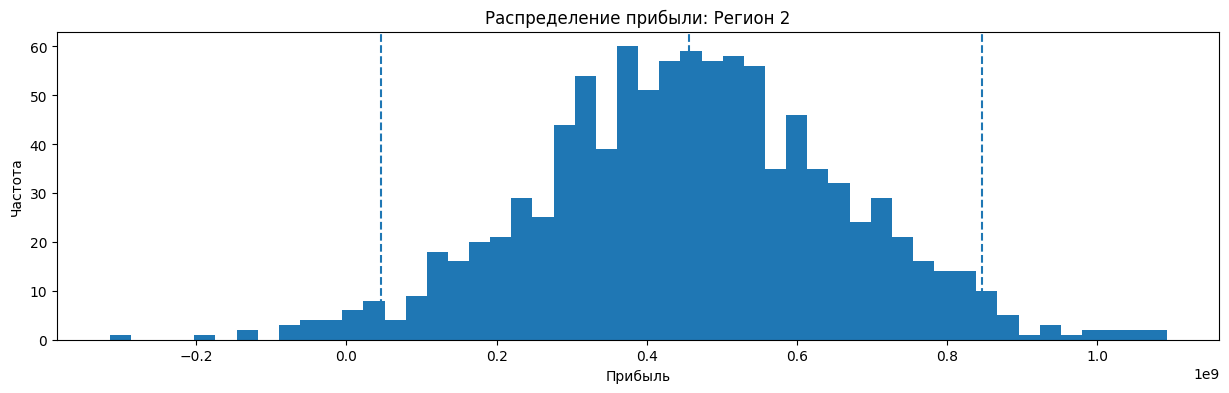

Регион: Регион 3
Средняя прибыль: 365417713
95% интервал: -172104950 - 912895453
Риск убытков: 7.5 %


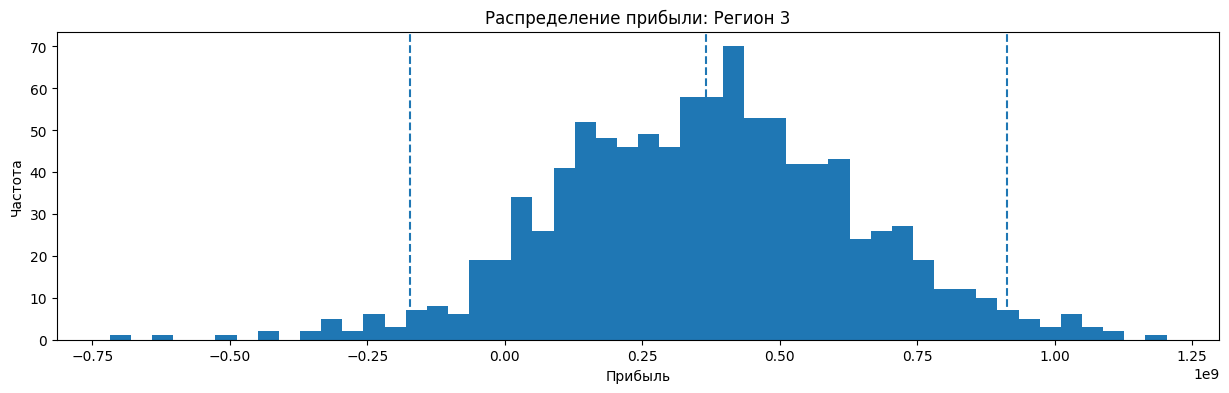

,Регион,Средняя прибыль,Нижняя граница 95%,Верхняя граница 95%,"Риск убытков, %"
0,Регион 1,"404,725,537.0","-128,938,940.8","868,914,568.3",6.2
1,Регион 2,"456,228,408.7","46,641,450.0","845,963,730.8",1.5
2,Регион 3,"365,417,713.3","-172,104,950.3","912,895,453.0",7.5


In [22]:
results = []

region_names = ['Регион 1', 'Регион 2', 'Регион 3']
total_val_df = [y_val1_df, y_val2_df, y_val3_df]

for i in range(3):
    
    region_df = total_val_df[i]
    region_name = region_names[i]
    
    profits = []
    
    for j in range(1000):
        sample = region_df.sample(n=POINTS_PER_REGION, replace=True)
        top = sample.sort_values('product_pred', ascending=False).head(DEVELOP_POINTS)
        
        total_real = top['product'].sum()
        profit = total_real * REVENUE_PER_UNIT - BUDGET
        profits.append(profit)
    
    profits = np.array(profits)
    
    mean_profit = profits.mean()
    ci_lower = np.percentile(profits, 2.5)
    ci_upper = np.percentile(profits, 97.5)
    loss_risk = (profits < 0).mean()
    
    print('Регион:', region_name)
    print('Средняя прибыль:', round(mean_profit))
    print('95% интервал:', round(ci_lower), '-', round(ci_upper))
    print('Риск убытков:', round(loss_risk * 100, 2), '%')
    
    plt.figure(figsize=(15, 4))
    plt.hist(profits, bins=50)
    plt.axvline(mean_profit, linestyle='--')
    plt.axvline(ci_lower, linestyle='--')
    plt.axvline(ci_upper, linestyle='--')
    plt.title('Распределение прибыли: ' + region_name)
    plt.xlabel('Прибыль')
    plt.ylabel('Частота')
    plt.show()
    
    results.append([region_name, mean_profit, ci_lower, ci_upper, loss_risk * 100])

results_df = pd.DataFrame(results, columns=['Регион', 'Средняя прибыль','Нижняя граница 95%', 'Верхняя граница 95%', 'Риск убытков, %'])
results_df


**Вывод по разделу:**
- По условиям задачи мы должны были найти регион, у которого вероятность убытков меньше 2.5%, при этом самая высокая прибыль. Но таким условиям у нас соответствует всего один регион - Регион 2. У него вероятность рисков меньше 2,5%, в то время как у других регионов эти риски существенно выше. И даже при этом условии у Региона 2 средняя прибыль всё равно выше, чем у других регионов. 

***Так что наш выбор - Регион 2***